## Parameters for MC simulation of stock prices#### Begin by simulating stock price dynamics under GBM.



In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt

In [6]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate

M = 1         # maturity
T = 24        # number of time steps

N_MC = 1000    # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

## GBM Simulation

#### Formulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps using the classical GBM formula:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where $W_t$ is a standard Brownian motion. The discrete form is given as:

$$
S_{t+1} = S_t \exp\left(\left(\mu - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} Z\right)
$$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

---
#### State Variable Calculation
Based on simulated stock price $S_t$, compute the state variable $X_t$ as:

$$
X_t = -\left(\mu - \frac{1}{2} \sigma^2\right)t\Delta t + \log S_t
$$

---
#### Additional Computations
1. Compute the difference:

$$
\Delta S_t = S_{t+1} - e^{r \Delta t} S_t
$$

2. Adjusted difference:

$$
\hat{\Delta S_t} = \Delta S_t - \overline{\Delta S_t}
$$

where $\overline{\Delta S_t}$ is the sample mean of all values of $\Delta S_t$ across the Monte Carlo paths.

---
#### Visualization of Results
- Plot 5 stock price paths $S_t$
- Plot 5 state variable paths $X_t$a S_t \) across the Monte Carlo paths.

---

## Visualization of Results

- Plot 5 stock price paths \( S_t \).
- Plot 5 state variable paths \( X_t \).
 S_t \).
- Plot 5 state variable paths \( X_t \).


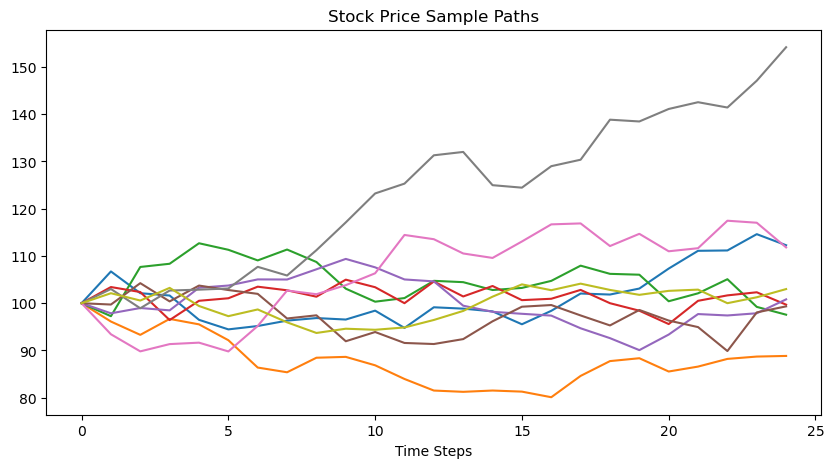

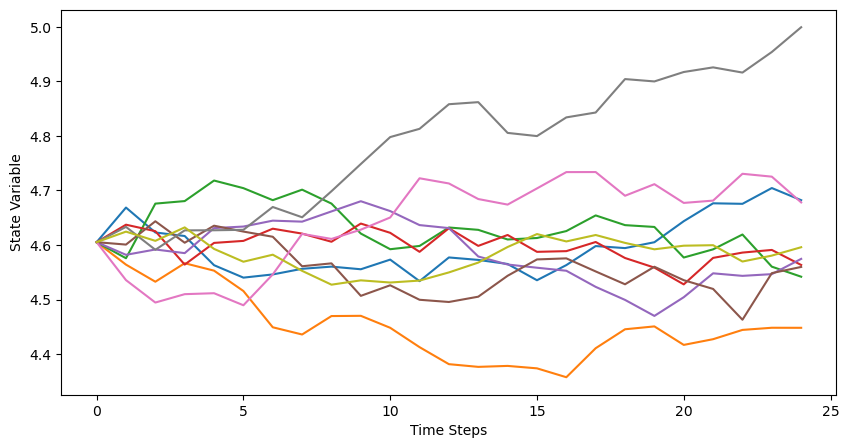

In [40]:
# make two datasets 
starttime = time.time()

# stock price initialization
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0
S_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_1.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))
RN_1 = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

# Generate paths
for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])
    S_1.loc[:,t] = S_1.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN_1.loc[:,t])

# Calculate differences
delta_S = S.iloc[:,1:].values - np.exp(r * delta_t) * S.iloc[:,:-1].values
delta_S_hat = pd.DataFrame(delta_S).apply(lambda x: x - np.mean(x), axis=0)
delta_S_1 = S_1.iloc[:,1:].values - np.exp(r * delta_t) * S_1.iloc[:,:-1].values
delta_S_hat_1 = pd.DataFrame(delta_S_1).apply(lambda x: x - np.mean(x), axis=0)

# state variable
time_array = np.arange(T+1) * delta_t
time_matrix = np.tile(time_array, (N_MC, 1))
X = pd.DataFrame(-1 * (mu - 1/2 * sigma**2) * time_matrix + np.log(S.values.astype(float)), 
                index=S.index, columns=S.columns)
X_1 = pd.DataFrame(-1 * (mu - 1/2 * sigma**2) * time_matrix + np.log(S_1.values.astype(float)), 
                  index=S_1.index, columns=S_1.columns)

# plot paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.figure(figsize=(10, 5))
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

#### Terminal Payoff Function
Define function `terminal_payoff` to compute the terminal payoff of a European put option:

$H_T(S_T) = \max(K - S_T, 0)$

In [43]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

## Define spline basis functions

X.shape =  (1000, 25)
X_min, X_max =  4.055605529240229 5.130027033174341
Number of points k =  17


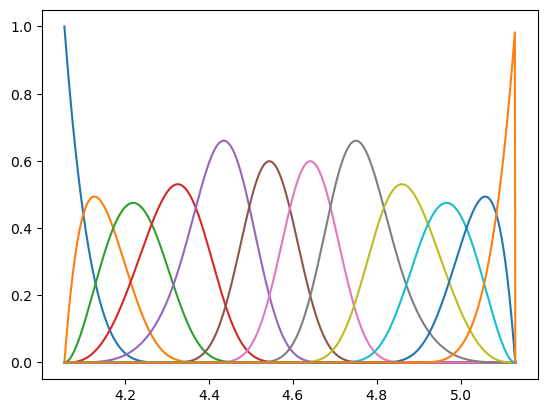

<Figure size 640x480 with 0 Axes>

In [50]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4 # order of spline (as-is; 3: cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
f = plt.figure()

print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [52]:
type(basis)

bspline.bspline.Bspline

### Make data matrices with feature values
"Features" here are the values of basis functions at data points The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [55]:
num_t_steps = T + 1
num_basis =  ncolloc 

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
data_mat_t_1 = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()

# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    x_1 = X_1.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(i) for i in x ])
    data_mat_t_1[i,:,:] = np.array([ basis(i) for i in x_1 ])
    
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (25, 1000, 12)
Computational time: 7.177961349487305 seconds


In [57]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)
np.save('data_mat_m=r_B_%d' % N_MC, data_mat_t_1)

print(data_mat_t.shape) # shape: num_steps x N_MC x num_basis
print(len(k))

(25, 1000, 12)
17


#### Dynamic Programming Solution for QLBS

The MDP problem solves the following Bellman optimality equation for the action-value function:

$$
Q_t^*(x,a) = \mathbb{E}_t\left[R_t(X_t,a_t,X_{t+1}) + \gamma \max_{a_{t+1}\in\mathcal{A}} Q_{t+1}^*(X_{t+1},a_{t+1}) \mid X_t = x, a_t = a\right], \quad t=0,\ldots,T-1, \quad \gamma = e^{-r\Delta t}
$$

where $R_t(X_t,a_t,X_{t+1})$ is the one-step time-dependent random reward and $a_t(X_t)$ is the action (hedge).

Using basis functions $\{\Phi_n(X_t^k)\}_{n=1}^N$, expand the optimal action (hedge) $a_t^*(X_t)$ and optimal Q-function $Q_t^*(X_t,a_t^*)$ as:

$$
a_t^*(X_t) = \sum_{n=1}^N \phi_{nt}\Phi_n(X_t) \qquad Q_t^*(X_t,a_t^*) = \sum_{n=1}^N \omega_{nt}\Phi_n(X_t)
$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T-1,\ldots,0$.

Coefficients for expansions of optimal action $a_t^*(X_t)$ are solved by:

$$
\phi_t = \mathbf{A}_t^{-1}\mathbf{B}_t
$$

where $\mathbf{A}_t$ and $\mathbf{B}_t$ are matrix and vector with elements:

$$
A_{mn}^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_n(X_t^k)\Phi_m(X_t^k)(\Delta S_t^k)^2 \qquad 
B_m^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_m(X_t^k)\left[\Pi_{t+1}^k\Delta S_t^k + \frac{1}{2\gamma\lambda}(\Delta S_t^k)^2\right]
$$

Define functions `function_A` and `function_B` to compute matrix $\mathbf{A}_t$ and vector $\mathbf{B}_t$.

In [60]:
risk_lambda = 0.001 # risk aversion parameter

K = 100 # strike  

# Note that I set coef=0 below in function function_B_vec. This corresponds to a pure risk-based hedging

In [87]:
# functions to compute optimal hedges
def function_A_vec(t,delta_S_hat,data_mat,reg_param):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:,t].values
    hat_dS2 = (this_dS**2).reshape(-1,1)    
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat
        
def function_B_vec(t, Pi_hat, delta_S=delta_S, delta_S_hat=delta_S_hat, S=S, data_mat=data_mat_t,
                  gamma=gamma,risk_lambda=risk_lambda):
    # coef = 1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    coef = 0
    tmp =  Pi_hat.loc[:,t+1] * delta_S_hat.loc[:,t] + coef * (np.exp(mu*delta_t) - np.exp(r*delta_t))* S.loc[:,t]
    X_mat = data_mat_t[t,:,:]  # matrix of dimension N_MC x num_basis
    
    B = np.dot(X_mat.T, tmp)    
    return B

#### Compute Optimal Hedge and Portfolio Value

Call `function_A` and `function_B` for $t=T-1,\ldots,0$ with basis function $\Phi_n(X_t)$ to compute optimal action $a_t^*(X_t)=\sum_{n=1}^N \phi_{nt}\Phi_n(X_t)$ backward recursively with terminal condition $a_T^*(X_T)=0$.

Once optimal hedge $a_t^*(X_t)$ is computed, portfolio value $\Pi_t$ is computed backward recursively by:

$$
\Pi_t = \gamma[\Pi_{t+1} - a_t^*\Delta S_t] \quad t=T-1,\ldots,0
$$

with terminal condition $\Pi_T = H_T(S_T) = \max(K-S_T,0)$ for a European put option.

Also compute $\hat{\Pi}_t = \Pi_t - \bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

Plots of 5 optimal hedge $a_t^*$ and portfolio value $\Pi_t$ paths are shown below.

In [90]:
# Calculate portfolio values and optimal hedge
starttime = time.time()

# Initialize DataFrames
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

# Twin dataset initialization
Pi_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_1.iloc[:,-1] = S_1.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
Pi_hat_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat_1.iloc[:,-1] = Pi_1.iloc[:,-1] - np.mean(Pi_1.iloc[:,-1])
a_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_1.iloc[:,-1] = 0

reg_param = 1e-3

# Backward recursion
for t in range(T-1, -1, -1):
   # First dataset
   A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
   B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
   phi = np.linalg.solve(A_mat, B_vec)
   a.iloc[:,t] = np.dot(data_mat_t[t], phi)
   Pi.iloc[:,t] = gamma * (Pi.iloc[:,t+1] - a.iloc[:,t] * delta_S.iloc[:,t])
   Pi_hat.iloc[:,t] = Pi.iloc[:,t] - np.mean(Pi.iloc[:,t])
   
   # Twin dataset
   A_mat_1 = function_A_vec(t, delta_S_hat_1, data_mat_t_1, reg_param)
   B_vec_1 = function_B_vec(t, Pi_hat_1, delta_S_hat_1, S_1, data_mat_t_1, gamma, risk_lambda)
   phi_1 = np.linalg.solve(A_mat_1, B_vec_1)
   a_1.iloc[:,t] = np.dot(data_mat_t_1[t], phi_1)
   Pi_1.iloc[:,t] = gamma * (Pi_1.iloc[:,t+1] - a_1.iloc[:,t] * delta_S_1.iloc[:,t])
   Pi_hat_1.iloc[:,t] = Pi_1.iloc[:,t] - np.mean(Pi_1.iloc[:,t])

# Convert to float type
a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
a_1 = a_1.astype('float')
Pi_1 = Pi_1.astype('float')
Pi_hat_1 = Pi_hat_1.astype('float')

print(f'Computational time: {time.time() - starttime:.2f} seconds')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'